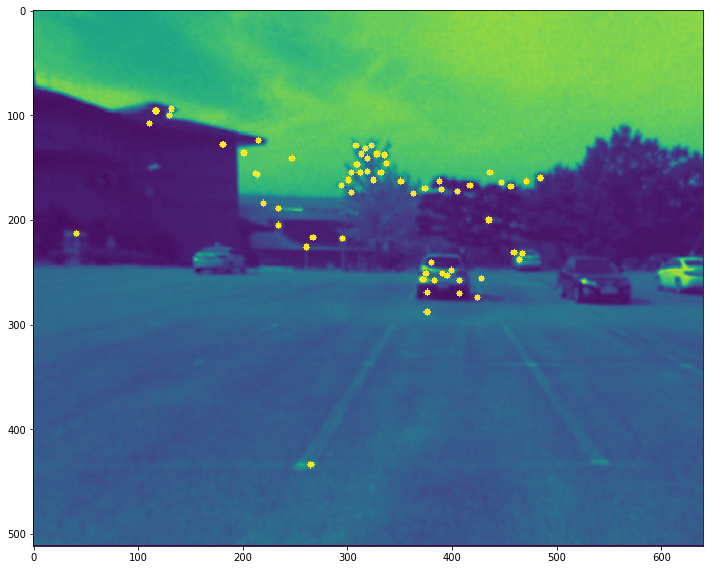

(<matplotlib.image.AxesImage at 0x7fb0b07d0dd8>, None)

In [2]:
# Might want to use higher resolution images

import numpy as np
import cv2
import cv2 as cv
import matplotlib.pyplot as plt
import os

def annotate_pt_lbl(img, pt, lbl):
    x, y = int(pt[0]), int(pt[1])
    cv2.circle(img,(x,y),3,255,-1)
    #cv2.putText(img, str(lbl), (x,y), cv2.FONT_HERSHEY_SIMPLEX, .5, (255,255,255))
    
def to_gray(img):
    #gray = ( b/3 + r/3 + g/3 )
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return gray

img_dir = '/media/sec/kaistPed/seq/set00/V000/visible'
img_name1 = 'I00100.jpg'
#img_name2 = 'I00113.jpg'
img_name2 = 'I00123.jpg'

img1_pt = os.path.join(img_dir, img_name1)
img1 = cv2.imread(img1_pt)
#img1 = cv2.resize(img1,None,fx=0.5,fy=0.5)
img1 = to_gray(img1)

img2_pt = os.path.join(img_dir, img_name2)
img2 = cv2.imread(img2_pt)
#img2 = cv2.resize(img2,None,fx=0.5,fy=0.5)
img2 = to_gray(img2)

ann_img1 = img1.copy()
ann_img2 = img2.copy()

# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
    
good_match_pair = []
for m1,m2 in matches:
    if m1.distance < .5 * m2.distance:
        good_match_pair.append( [m1.queryIdx, m1.trainIdx] )
    
fpts1 = []
fpts2 = []
for i,m_idx_pair in enumerate(good_match_pair):
    i1, i2 = m_idx_pair
    pt1 = kp1[i1].pt
    pt2 = kp2[i2].pt
    
    fpts1.append(pt1)
    fpts2.append(pt2)
    
    lbl = str(i)
    annotate_pt_lbl(ann_img1, pt1, lbl)
    annotate_pt_lbl(ann_img2, pt2, lbl)

plt.figure(figsize=(12,12))
plt.imshow(ann_img1),plt.show()

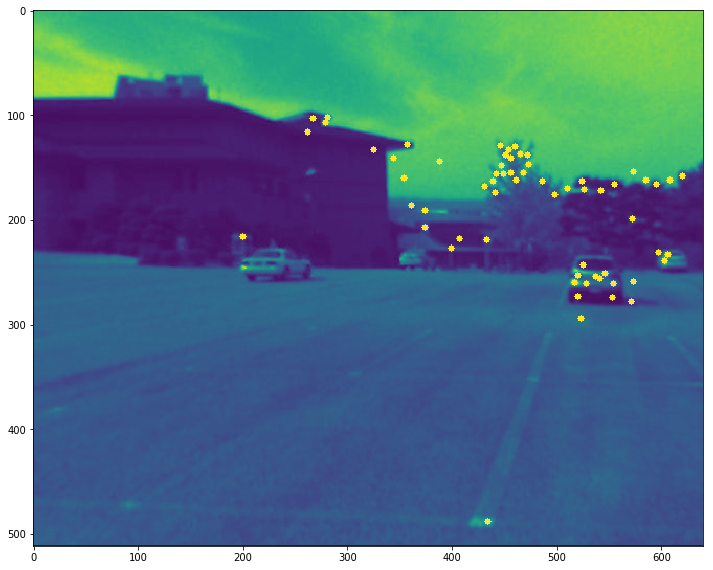

(<matplotlib.image.AxesImage at 0x7fb0b07bbe48>, None)

In [3]:
plt.figure(figsize=(12,12))
plt.imshow(ann_img2),plt.show()

In [64]:
import numpy as np
import math
# For sake of clarity of matrix operations, all points and vectors will be represented as matrices
# instead of the traditional list form.
# This means a point [x,y,z] will be expressed as [[x,y,z]] to denote a 1x3 matrix

def solve_homogenous_Ax(A):
    ''' With constraint that ||x||=1 '''
    U,S,V_trans = np.linalg.svd(A)
    V = V_trans.transpose()
    return V[:,-1] # Last column of V

def vec_mat(vec):
    M1 = vec[0:3].reshape( (1,3) )
    M2 = vec[3:6].reshape( (1,3) )
    M3 = vec[6:9].reshape( (1,3) )
    return np.concatenate( [M1, M2, M3], axis=0)


# Homography using constraint in P2: p_ x Hp = 0
# A cross product with itself is zero
def Hom_A_p(p, p_):
    x,y,w = p_[0]
    Z = np.array([[0,0,0]])
    A_1 = np.concatenate( [Z, -w*p, y*p], axis=1)
    A_2 = np.concatenate( [w*p, Z, -x*p], axis=1)
    #A_3 = np.concatenate( [-y*p, x*p, Z], axis=1) Omit third linear eq. since dependant on first two due to scale
    A = np.concatenate( [A_1, A_2], axis=0)
    return A

def Hom_A_P(P, P_):
    ''' Constructs the system of equations to compute (H)omography with 4 corresponding points'''
    As = []
    for p,p_ in zip(P,P_):
        As += [ Hom_A_p(p,p_) ]
    A = np.concatenate( As, axis=0 )
    return A

# Normalization
# Transformation applied to each image separately in the sequential steps
# Only modifying (x,y) 
# move centroid of all points to origin
# on average a point x is of the form (x,y,w) with each x,y,w having same average magnitude
# instead of choosing different scale factors for each coordinate, an isotrpoic scaling factor is
# chosen so that the x and y coordiantes of a point are scaled equally
# We choose to scale the coordinates so that the average distance of a point x from the origin is sqrt(2)
# This means the average point is equal to (1,1,1)

def get_centroid(P):
    ''' centroid: average of coordinates '''
    sum_P = np.zeros( (1,3) )
    for p in P:
        sum_P += p
    return sum_P/len(P)



def normalize_and_get_transform(P):
    # Note: I tied these to processes 'normalize' and 'get_transform' because the process of computing the transform involves normalizing.
    # If there isn't a huge performance boost, I would prefer separating these two processes however.
    # Since it would make more sense from an organizational standpoint
    # The UNIX Philosophy would claim that I should go in the direction of organization but I know from Tensorflow and Pytorch speed diff with matrix BCHW and BHWC that it is important at times
    # esp in a program where 'speed' is of importance
    # I think philosophies and things change on the importance and the values of the objects that one works with.
    
    tx, ty, _ = get_centroid(P) # we will translate by -x,-y of centeroid
    T_trans = np.array( [[1,0, -tx],
                         [0,1,-ty],
                         [0,0,1]])
    centered_P = []
    for p in P:
        centered_P += [ T_trans@p.T ]
    
    def dist(p):
        x,y,_ = p[0]
        return math.sqrt( x**2 + y**2 )
    
    dist_sum = 0
    for p in centered_P:
        dist_sum += dist(p)
    avg_dist = dist_sum/len(P)
    k = math.sqrt(2) / avg_dist
    
    T_scale = np.array( [[k,0,0],
                         [0,k,0],
                         [0,0,1]])
    
    scaled_centered_P = []
    for p in centered_P:
        scaled_centered_P += [ T_scale@p.T]
    return scaled_centered_P, T_scale@T_trans

from numpy.linalg import inv
def unorm_H(H,T):
    return inv(T)@H@T

# Fundamental Matrix using contraint in P. Normalized 8 point algorithm
# Constraint x`Fx = 0
def Fund_A_p(p, p_):
    x ,y ,_ = p[0]
    x_,y_,_ = p_[0]
    A = [[x_*x, x_*y, x_, y_*x, y_*y, y_, x, y, 1]]
    return np.array(A)
    
    
def Fund_A_P(P,P_):
    '''Construct a matrix A for calculating fund matrix'''
    As = []
    for p,p_ in zip(P,P_):
        As += [ Fund_A_p(p,p_) ]
    A = np.concatenate( As, axis=0 )
    return A

def Fund_loss(F, p, p_):
    # 12.5.2 Multiple View Geometry
    # Algorithm proceeds as follows
    # Transform image coordinates so that the point of interest lie at origin
    # find epipolar line wrt t such that distance is minimized
    # TODO: find the point on these lines that minize distance between the lines in the origin\
    # TODO: project 3d poiont X using these predicted image points on the lines
    
    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])
    T_ = np.array([[1, 0, -tx_],
                   [0, 1, -ty_],
                   [0, 0, 1]])
    
    F = inv(T_.T) @ F @ inv(T)

    # e and e_ are solutions to F@e = 0 and e_@F=0 and will solve using SVD
    # "However, due to noise, F’ may not be singular. So instead, next best thing is eigenvector associated with smallest eigenvalue of F" (http://www.cse.psu.edu/~rtc12/CSE486/lecture19_6pp.pdf)
    e = solve_homogenous_Ax(F)
    e = e/e[2]
    # e_@F=0 we want to write this as a right multiplication and it is F.T @ e_ = 0
    e_= solve_homogenous_Ax(F.T)
    e_ = e_/e_[2]
    
    #now scale e so that e1^2 + e2^2 = 1 to construct the rotation matrix
    k = math.sqrt( 1/(e[0]**2 + e[1]**2))
    k_ = math.sqrt( 1/(e_[0]**2 + e_[1]**2))
    e = k*e
    e_ = k_*e_
    
    R = np.array([[  e[0], e[1], 0 ],
                  [ -e[1], e[0], 0 ],
                  [     0,    0, 1 ]])
    R_ = np.array([[  e_[0], e_[1], 0 ],
                  [ -e_[1], e_[0], 0 ],
                  [     0,    0, 1 ]])
    
    F = R@F@R.T
    
    # Construction equation to minimizae distance
    f, f_ = e[2], e_[2]
    a, b, c, d = F[2,2], F[2,3], F[3,2], F[3,3]
    # roots of  t((at+b)^2 +p^2(ct+d)^2 )^2-(ad-bc)(1+f^2t^2)^2(at+b)(ct+d)  (eq12.7) #f_ is p here
    # numpy.roots()
    # The algorithm relies on computing the eigenvalues of the companion matrix
    # Use the Collect( eq, t) in Wolfram
    # t^3 (6 a^2 b^2 + 2 a^2 d^2 f_^2 + 2 b c f^2 (b c - a d) + 2 a d f^2 (b c - a d) + 8 a b c d f_^2 + 2 b^2 c^2 f_^2 + 6 c^2 d^2 f_^4) + 
    # t^5 (a^4 + 2 a^2 c^2 f_^2 + a d f^4 (b c - a d) + b c f^4 (b c - a d) + c^4 f_^4) +
    # t^4 (4 a^3 b + 4 a^2 c d f_^2 + 4 a b c^2 f_^2 + b d f^4 (b c - a d) + 2 a c f^2 (b c - a d) + 4 c^3 d f_^4) + 
    # t (b c (b c - a d) + a d (b c - a d) + b^4 + 2 b^2 d^2 f_^2 + d^4 f_^4) + 
    # t^2 (4 a b^3 + 2 b d f^2 (b c - a d) + a c (b c - a d) + 4 a b d^2 f_^2 + 4 b^2 c d f_^2 + 4 c d^3 f_^4) + 
    # t^6 a c f^4 (b c - a d) + 
    # b d (b c - a d)
    coeff_eq = [ a * c * f**4 * (b * c - a * d), #t^6
                (a**4 + 2 * a**2 * c**2 * f_**2 + a * d * f**4 * (b * c - a * d) + b * c * f**4 * (b * c - a * d) + c**4 * f_**4), #t^5
                (4 * a**3 * b + 4 * a**2 * c * d * f_**2 + 4 * a * b * c**2 * f_**2 + b * d * f**4 * (b * c - a * d) + 2 * a * c * f**2 * (b * c - a * d) + 4 * c**3 * d * f_**4), #t^4
                (6 * a**2 * b**2 + 2 * a**2 * d**2 * f_**2 + 2 * b * c * f**2 * (b * c - a * d) + 2 * a * d * f**2 * (b * c - a * d) + 8 * a * b * c * d * f_**2 + 2 * b**2 * c**2 * f_**2 + 6 * c**2 * d**2 * f_**4), #t^3
                (4 * a * b**3 + 2 * b * d * f**2 * (b * c - a * d) + a * c * (b * c - a * d) + 4 * a * b * d**2 * f_**2 + 4 * b**2 * c * d * f_**2 + 4 * c * d**3 * f_**4), #t^2
                (b * c * (b * c - a * d) + a * d * (b * c - a * d) + b**4 + 2 * b**2 * d**2 * f_**2 + d**4 * f_**4), #t^1
                b * d * (b * c - a * d)] #t^0
    real_roots = np.real( np.roots(coeff_eq) )
    def sq_dist(t, f,f_, a,b,c,d):
        return (t**2)/(1 + f**2*t**2) + ( (c*t+d)**2 )/( (a*t+b)**2 + f_**2*(c*t+d)**2 )
    
    sq_dists = [sq_dist(t,f,f_,a,b,c,d) for t in real_roots]
    min_t = np.argmin(sq_dists)
    return sq_dists[min_t]
    
def Fund_loss(F, P, P_):
    pass
    # For each pair of correspondences in P and P_,
    # We estimate the loss by finding image points predicted by F from one correspondence to another.
    # We do this by parameterizing the epipolar lines constructed from the epipole in IMG1 and projecting this line to IMG2
    # Then finding t (and consequently the line) that minimizes the distance between the point and the line (for IMG1 and IMG2)
    # The sum of distances between the line and point in IMG1 and IMG2 is the loss
    
    # It would be nice to return the epipolar line t and the corresponding predicted points since these will be used in the reconstruction
    
# Reconstruction the Motion
def Fund_RT(F):
    pass
# Reconstruction the Scene
def Fund_points(F):
    pass

def norm_RANSAC_Hom():
    
    pass
def norm_RANSAC_Fund():
    pass

# How do we know that the inverse will exist?
# (Loss function will be symmetric transfer error) d( x',Hx )+d( x,inv(H)x' )
# (Loss function for fundamental will be distance between epipolar line and corresponding point?)
# RANSAC
# inlier, outlier
# FOR each iteration select n random points
#    fit the transformation/model
#    check against all other points and see how many outliers are there (dependent on some loss func)
#    IF outliers < tresh then success.
#       maybe (refit the model using all inliers)
#       compare the error of the newly fit model and the current_best model
#
# (keep a collection of current best model and pick the best)

   
# Motion and Structure(depth) Recovery


def test_hom_1():
    a = np.random.random( (1,3) )
    b = np.random.random( (1,3) )
    c = np.random.random( (1,3) )
    d = np.random.random( (1,3) )
    A = Hom_A_P( [a,b,c,d],[a,b,c,d] )
    print('A',A.round(2))
    h = solve_homogenous_Ax(A).round(2)
    H = vec_mat(h)
    print('Test Hom 1: should print scale-equivalent identity')
    print(H)
    
def test_fund_1():
    a = np.random.random( (1,3) )
    b = np.random.random( (1,3) )
    c = np.random.random( (1,3) )
    d = np.random.random( (1,3) )

    A = Fund_A_P( [a,b,c,d,a,b,c,d],[a,b,c,d,a,b,c,d] )
    print('A\n',A.round(2))
    f = solve_homogenous_Ax(A).round(2)
    F = vec_mat(f)
    print('Test Fund 1: x_Fx should be zero')
    x = np.random.random( (1,3) )
    print('F\n',F.round(2))
    print( 'xFx\n',x@F@x.T )


In [129]:
c = np.zeros( (1,3) )
c += np.ones( (1,3) )
c += np.ones( (1,3) )
c /= 2
np.array( [3,2,3]) * np.array( [3,2,3])
k = np.random.random( (3,3) )
np.matmul(k,k) == k@k

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [41]:
import numpy as np
A = np.array([[-0.00310695, -0.0025646, 2.96584],
              [-0.028094, -0.00771621, 56.3813],
              [13.1905, -29.2007, -9999.79]])

c = solve_homogenous_Ax(A)
print(c)
print(c/[c[2]])
c = np.array([[ 0.39879571, -0.91264384,  0.08968386]]).T
A.shape, c.shape
A[0,:].dot(c)

[-9.65984291e-01 -2.58600231e-01 -5.19061692e-04]
[1.86102019e+03 4.98207120e+02 1.00000000e+00]


array([0.26708951])

In [63]:
a,b,c,d,f,f_ = 1,2,3,4,5,6
t=1

[t**6 * a * c * f**4 * (b * c - a * d),
t**5 * (a**4 + 2 * a**2 * c**2 * f_**2 + a * d * f**4 * (b * c - a * d) + b * c * f**4 * (b * c - a * d) + c**4 * f_**4),
t**4 * (4 * a**3 * b + 4 * a**2 * c * d * f_**2 + 4 * a * b * c**2 * f_**2 + b * d * f**4 * (b * c - a * d) + 2 * a * c * f**2 * (b * c - a * d) + 4 * c**3 * d * f_**4),
t**3 * (6 * a**2 * b**2 + 2 * a**2 * d**2 * f_**2 + 2 * b * c * f**2 * (b * c - a * d) + 2 * a * d * f**2 * (b * c - a * d) + 8 * a * b * c * d * f_**2 + 2 * b**2 * c**2 * f_**2 + 6 * c**2 * d**2 * f_**4),
t**2 * (4 * a * b**3 + 2 * b * d * f**2 * (b * c - a * d) + a * c * (b * c - a * d) + 4 * a * b * d**2 * f_**2 + 4 * b**2 * c * d * f_**2 + 4 * c * d**3 * f_**4),
t * (b * c * (b * c - a * d) + a * d * (b * c - a * d) + b**4 + 2 * b**2 * d**2 * f_**2 + d**4 * f_**4),
b * d * (b * c - a * d)]
import math
a = np.real( [-0.3125+0.46351241j,-0.3125+0.46351241j])
np.argmax(a)

0

In [89]:

a = list(range(5))
b = list(range(5))

import random
z = list( zip(a,b) )
random.sample(z, 4)
random.shuffle(z)
a,b = zip(*z)


TypeError: zip argument #1 must support iteration